### 1. Import the Required Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import wandb

### 2. Set Device

In [3]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3. Data Loading and Processing

In [4]:
class KTHProcessedDataset(Dataset):
    def __init__(self, root_dir, sequence_length=15, transform=None):
        """
        root_dir: path of the parent directory that contains processed frames/images.
        sequence_length: the number of frames in each subsequence.
        transforms: augmentations applied to the frames (can be none or more).
        """
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.data = []
        self.class_mapping = {}

        # Parse through categories
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            category_path = os.path.join(root_dir, category)
            # if not os.path.isdir(category_path):
            #     continue
            self.class_mapping[label] = category
            for subfolder in os.listdir(category_path):
                subfolder_path = os.path.join(category_path, subfolder)
                if os.path.isdir(subfolder_path): # check (folder also contain some json)
                    frames = sorted(os.listdir(subfolder_path))

                    # Create subsequences from frames
                    for start_idx in range(0, len(frames) - sequence_length + 1, sequence_length):  # (0, 450-15+1, 15)
                        subsequence_frames = frames[start_idx:start_idx + sequence_length]          # (0, 0+15), then (15, 30) and so on.
                        if len(subsequence_frames) == sequence_length:
                            self.data.append((subfolder_path, subsequence_frames, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subfolder_path, frames, label = self.data[idx]

        sequence = []
        for frame_file in frames:
            frame_path = os.path.join(subfolder_path, frame_file)
            try:
                img = Image.open(frame_path).convert("L")
                if self.transform:
                    img = self.transform(img)

                img = img.view(-1)
                sequence.append(img)

            except Exception as e:
                # Found some corrupted image in the folders
                print(f"Skipping image {frame_path} due to error: {e}")
                return self.__getitem__((idx + 1) % len(self))

        # Stack frames into tensor
        sequence = torch.stack(sequence, dim=0)
        return sequence, label


- No image resizing is done because the processed frames are of size 64x64.
- Images are converted to Grayscale (64x64=4096 pixels) since it will save some computation time (and the images are also grayscale so we don't lose any information). For RGB the number of pixels will be 3 x 4096.

#### Define augmentations

In [5]:
# Define augmentations
transform = transforms.Compose([
    
    # RandomHorizontalFlip(p=0.5),
    # RandomRotation(degrees=15),
    transforms.RandomCrop(size=(64, 64), pad_if_needed=True),

    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    
    transforms.ToTensor(),                             
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Taking the sequence length because I observed that in some of the categories like jogging, the first 7-8 frames are empty and till the 40-45th frames we get a complete motion i.e. person comes in running in the frame and then goes out after that the frames are again empty till the person again comes from the opposite direction.

In [6]:
# Paths and hyperparameters
root_dir = '/home/nfs/inf6/data/datasets/kth_actions/processed'
sequence_length = 45
batch_size = 16
train_ratio = 0.8  # 80% for train 20% for val

In [7]:
# Load the whole dataset
dataset = KTHProcessedDataset(root_dir=root_dir, sequence_length=sequence_length, transform=transform)

# Calculate train and validation sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split dataset into train and val
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders for train and val sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Dataset size: {dataset_size}")
print(f"Train set size: {train_size}")
print(f"Validation set size: {val_size}")

Dataset size: 6150
Train set size: 4920
Validation set size: 1230


In [8]:
print("Dataset Classes:")
for class_id, class_name in dataset.class_mapping.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

Dataset Classes:
Class ID: 0, Class Name: boxing
Class ID: 1, Class Name: handclapping
Class ID: 2, Class Name: handwaving
Class ID: 3, Class Name: jogging
Class ID: 4, Class Name: running
Class ID: 5, Class Name: walking


In [9]:
# reverse mapping of the dataclasses
reverse_mapping = {val:key for key,val in dataset.class_mapping.items()}
reverse_mapping

{'boxing': 0,
 'handclapping': 1,
 'handwaving': 2,
 'jogging': 3,
 'running': 4,
 'walking': 5}

#### Visualize dataset

In [10]:
def visualize_sequences(dataset, category_label, num_sequences=3, sequence_length=15):
    """
    Visualizes the first `num_sequences` sequences for a specific category label.
    
    Args:
        dataset: Instance of KTHProcessedDataset.
        category_label: Label of the category to visualize.
        num_sequences: Number of sequences to visualize.
        sequence_length: Length of each sequence.
    """
    sequences_shown = 0
    
    plt.figure(figsize=(15, num_sequences * 3))
    for i in range(len(dataset)):
        sequence, label = dataset[i]
        if label == category_label:
            for frame_idx in range(sequence_length):
                plt.subplot(num_sequences, sequence_length, sequences_shown * sequence_length + frame_idx + 1)
                frame = sequence[frame_idx].view(64, 64).cpu().numpy()
                plt.imshow(frame, cmap="gray")
                plt.axis("off")
            
            sequences_shown += 1
            if sequences_shown >= num_sequences:
                break

    plt.suptitle(f"Sequences for category label: {category_label}", fontsize=16)
    plt.show()

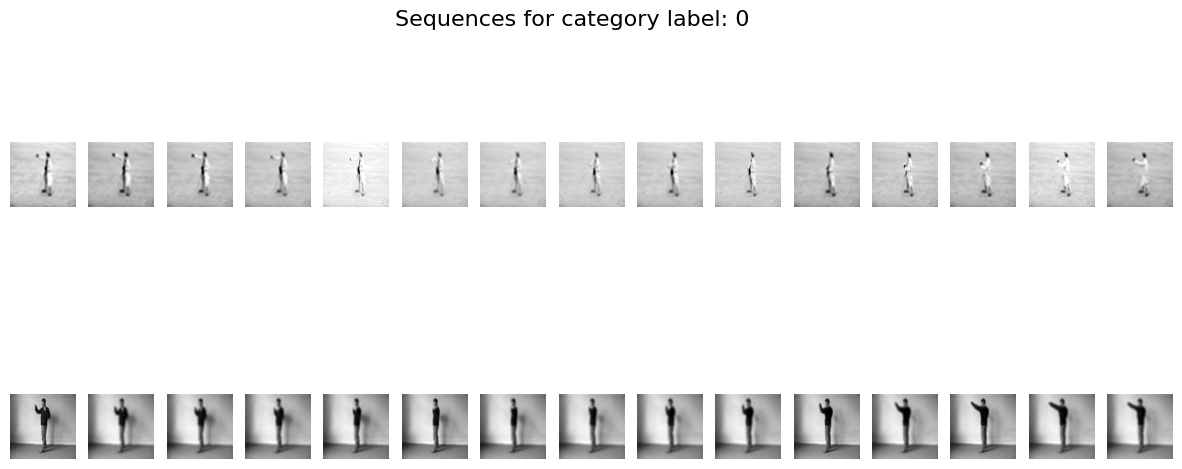

In [11]:
# Visualize sequences for category label 0 (e.g., walking)
category_name = 'boxing'
visualize_sequences(val_dataset, category_label=reverse_mapping[category_name], num_sequences=2, sequence_length=15)

### Training and Validation Code

This is the same code as used in the previous assignments with minor changes and integration of 'Weigths and Biases' for logging of metrics.

In [12]:
def train_nn(model, train_loader, criterion, optimizer, device):
    """Train  model for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy
        _, predicted_labels = torch.max(outputs, dim=1)
        correct_labels += (predicted_labels == labels).sum().item()
        total_labels += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def evaluate_nn(model, eval_loader, criterion, device):
    """Evaluate the model after each epoch."""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Compute accuracy
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_labels += (predicted_labels == labels).sum().item()
            total_labels += labels.size(0)

    avg_loss = running_loss / len(eval_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def run_training(model, train_loader, eval_loader, criterion, device, num_epochs, learning_rate=0.001, step_size=5, gamma=0.5,
                 project='lstm_training', name='test_run'):
    """Train and evaluate the model for a given number of epochs with W&B logging"""

    # Initialize W&B logging
    wandb.init(project=project, name=name, config={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "step_size": step_size,
        "gamma": gamma,
        "optimizer": "Adam",
    },
    )
    config = wandb.config

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizer
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    
    train_losses = []
    eval_losses = []
    train_accuracies = []
    eval_accuracies = []
    learning_rates = []

    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        # Evaluate after each epoch
        eval_loss, eval_accuracy = evaluate_nn(model, eval_loader, criterion, device)

        current_lr = scheduler.get_last_lr()[0]


        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        train_accuracies.append(train_accuracy)
        eval_accuracies.append(eval_accuracy)
        learning_rates.append(current_lr)

        # Log metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "eval_loss": eval_loss,
            "eval_accuracy": eval_accuracy,
            "learning_rate": current_lr
        })

        # Print stats after each epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Step the LR scheduler
        scheduler.step()

    # End W&B run
    wandb.finish()

    return model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates

### Result Visualization

In [13]:
def plot_confusion_matrix(y_true, y_pred, label_names, model_name):
    """
    Plots confusion matrix for a given model.

    Args:
        y_true (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        label_names (list): List of class names.
        model_name (str): The name of the model to display in the plot title.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names, linewidths=1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [14]:
# Function to evaluate model and compute predictions
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

#### LSTM  and LSTM Cell from Scratch

Inspired from 
1. https://github.com/hadi-gharibi/pytorch-lstm/blob/master/lstm.ipynb
2. https://github.com/georgeyiasemis/Recurrent-Neural-Networks-from-scratch-using-PyTorch

both sources have highly similar code

In [21]:
### This works

class LSTMCell(nn.Module):
    """
    Custom LSTM Cell implementation from scratch
    
    Args:
    - input_size: Number of input features
    - hidden_size: Number of hidden units
    """
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # all gates weight combined into signle matrix
        # ih -> input_hidden
        # hh -> hidden_hidden
        self.weight_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))  
        self.weight_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        
        # Bias term
        self.bias_ih = nn.Parameter(torch.empty(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.empty(4 * hidden_size))
        
        # Initialize weights
        std = 1.0 / np.sqrt(self.hidden_size)
        nn.init.uniform_(self.weight_ih, -std, std)
        nn.init.uniform_(self.weight_hh, -std, std)
        nn.init.uniform_(self.bias_ih, -std, std)
        nn.init.uniform_(self.bias_hh, -std, std)
    
    def forward(self, x, hidden_state=None):
        """
        Forward pass for LSTM Cell
        
        Args:
        - x: input tensor of shape (batch_size, input_size)
        - hidden_state: tuple of (h, c) - previous hidden and cell states
        
        Returns:
        - new_h: new hidden state
        - new_c: new cell state
        """
        # Initialize hidden state if not provided
        if hidden_state is None:
            batch_size = x.size(0)
            h = x.new_zeros(batch_size, self.hidden_size)
            c = x.new_zeros(batch_size, self.hidden_size)
        else:
            h, c = hidden_state
        
        # Compute gate inputs
        gates = F.linear(x, self.weight_ih, self.bias_ih) + F.linear(h, self.weight_hh, self.bias_hh)
        
        # Split gates into 4 equal parts
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        # Apply activation
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        
        # new cell state
        new_c = (forgetgate * c) + (ingate * cellgate)
        
        # new hidden state
        new_h = outgate * torch.tanh(new_c)
        
        return new_h, new_c

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, batch_first=True):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        
        # Create LSTM cells for each layer
        self.lstm_cells = nn.ModuleList()
        for i in range(num_layers):
            layer_input_size = input_size if i == 0 else hidden_size
            self.lstm_cells.append(LSTMCell(layer_input_size, hidden_size))
        
        # Classification layer
        self.classifier = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        if not self.batch_first:
            x = x.transpose(0, 1)
        
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden states
        h_list = []
        c_list = []
        for _ in range(self.num_layers):
            h_list.append(torch.zeros(batch_size, self.hidden_size, device=x.device))
            c_list.append(torch.zeros(batch_size, self.hidden_size, device=x.device))


        all_h_states = []

        for t in range(seq_len):
            # Current input at time  t
            input_t = x[:, t, :]
            
            for layer in range(self.num_layers):
                cell = self.lstm_cells[layer]
                
                # Use previous layer hidden state as input
                h_prev = input_t if layer == 0 else h_list[layer-1]
                
                # Update hidden and cell states
                h_list[layer], c_list[layer] = cell(h_prev, (h_list[layer], c_list[layer]))
            
            
            all_h_states.append(h_list[-1])

        # Stack the hidden states for all time steps
        all_h_states = torch.stack(all_h_states, dim=1)  # Shape: [batch_size, seq_len, hidden_size]

        
        output = self.classifier(all_h_states)

        return output


In [26]:
class ActionClassificationModel(nn.Module):
    def __init__(self, sequence_length, input_dim=64*64, num_classes=6, rnn_module='scratch_lstm'):
        super(ActionClassificationModel, self).__init__()
        self.sequence_length = sequence_length

        # Encoder Block
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
        )

        # RNN modules to be put here
        if rnn_module == 'scratch_lstm':
            # Custom LSTM Module
            self.rnn = LSTM(
                input_size=256 * 8 * 8,
                hidden_size=256,         
                num_layers=2,           
                num_classes=256,    
                batch_first=True
            )
        else:
            print("Error")


        # Classifier
        self.classifier = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Reshape each frame
        x = x.view(batch_size * seq_len, 1, 64, 64)
        x = self.encoder(x)
        x = x.view(batch_size, seq_len, -1)
        
        # Recurrent Module
        x = self.rnn(x)  
        
        # print("Debug:", x.shape)
        
        # Classifier
        x = x.transpose(1, 2)
        x = self.classifier(x)
        
        return x

In [27]:
# Hyper parameters for LSTM
input_size = 64*64  # flattened size of frame
hidden_size = 256  # Hidden size of the LSTM
num_classes = len(os.listdir("/home/nfs/inf6/data/datasets/kth_actions/processed"))  # Number of output classes
num_layers = 2

# Hyperparameters for training
num_epochs = 30
learning_rate = 0.001  # Initial learning rate
step_size = 5          # To be used in LR Scheduler
gamma = 0.5            # To be used in LR Scheduler
name = f"lstm_scratch_ep_{num_epochs}_lr_{learning_rate}"
project = 'assignment_4'

#criterion
criterion = nn.CrossEntropyLoss()

In [28]:
model = ActionClassificationModel(input_dim=input_size, 
                                           sequence_length=sequence_length, 
                                           num_classes=num_classes).to(device)
model

ActionClassificationModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dr

In [ ]:
# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, 
    train_loader, val_loader, 
    criterion,
    device,
    num_epochs=num_epochs, 
    learning_rate=learning_rate, 
    step_size=step_size, 
    gamma=gamma,
    name=name, project=project
)

  0%|                                                                | 0/30 [00:00<?, ?it/s]